In [1]:
import os
import sys
import pathlib

import numpy as np
from scipy import ndimage as ndi
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import center_of_mass
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
import skimage.morphology as morph
import skimage.measure as meas
from skimage.transform import radon

import matplotlib.pyplot as plt

import astropy
from astropy.io import fits

import discorpy.losa.loadersaver as io
import discorpy.prep.preprocessing as prep
import discorpy.prep.linepattern as preplin
import discorpy.proc.processing as proc
import discorpy.post.postprocessing as post

In [2]:
def plot_image(arr):

    plt.figure()
    plt.imshow(arr, cmap='gray')
    plt.title(f"Image")
    plt.axis("off")    
    plt.show()    

In [3]:
def plot_image_view(list_lines, height, width, overwrite=True,
                    dpi=100):
    """
    Save the plot of dot-centroids to an image. Useful to check if the dots
    are arranged properly where dots on the same line having the same color.

    Parameters
    ----------
    file_path : str
        Output file path.
    list_lines : list of array_like
        List of 2D arrays. Each list is the coordinates of dots on a line.
    height : int
        Height of the image.
    width : int
        Width of the image.
    overwrite : bool, optional
        Overwrite the existing file if True.
    dpi : int, optional
        The resolution in dots per inch.

    Returns
    -------
    str
        Updated file path.
    """
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(width / dpi, height / dpi)
    ax = plt.Axes(fig, [0., 0., 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.axis((0, width, 0, height))
    m_size = 0.5 * min(height / dpi, width / dpi)
    for line in list_lines:
        plt.plot(line[:, 1], height - line[:, 0], '-o', markersize=m_size)  
    plt.show()    
   
   


In [4]:
hdul=fits.open('/Users/detoma/Desktop/work/UCOMP/distortion/grid0_new.fts')
data0 = hdul[0].data[ :, :]
#    header= hdul[0].header   
(height0, width0) = data0.shape

hdul=fits.open('/Users/detoma/Desktop/work/UCOMP/distortion/grid1_new.fts')
data1 = hdul[0].data[ :, :]
#    header= hdul[0].header   
(height1, width1) = data1.shape

print ( np.median(data0), np.median(data1) )



4328.384 4336.666


In [5]:
def _select_roi(mat, ratio, square=False):
    """
    Select ROI around the middle of an image.

    Parameters
    ----------
    mat : array_like
        2D array.
    ratio : float
        Ratio between the ROI size and the image size.
    square : bool, optional
        To get a square area or not.

    Returns
    -------
    array_like
        2D array.
    """
    (height, width) = mat.shape
    ratio = np.clip(ratio, 0.05, 1.0)
    if square is True:
        c_hei = height // 2
        c_wid = width // 2
        radi = int(ratio * min(height, width)) // 2
        mat_roi = mat[c_hei - radi:c_hei + radi, c_wid - radi: c_wid + radi]
    else:
        depad_hei = int((height - ratio * height) / 2)
        depad_wid = int((width - ratio * width) / 2)
        mat_roi = mat[depad_hei:height - depad_hei, depad_wid:width - depad_wid]
    return mat_roi


In [6]:
#plot_image(data0) 
#plot_image(data1)

In [7]:
num_coef = 5  # Number of polynomial coefficients

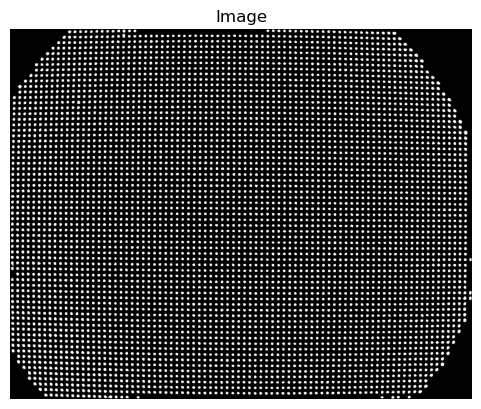

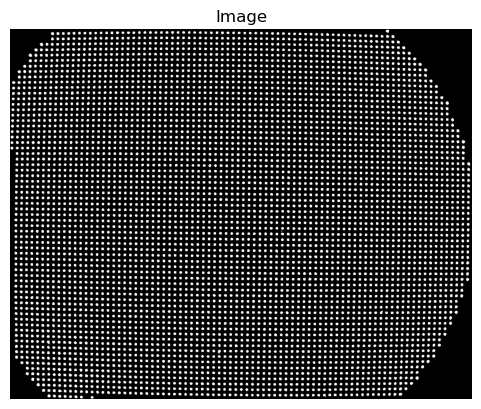

In [8]:
# Correct non-uniform background.
#mat0 = prep.binarization(data0)
#mat1 = prep.binarization(data1)

#data0 = prep.normalization_fft(data0,sigma=20,pad=100, mode='reflect')
#data1 = prep.normalization_fft(data1,sigma=20,pad=100, mode='reflect')

# Segment dots
#threshold0 = prep.calculate_threshold(data0, bgr="bright", snr=2)
threshold0 = 3300.
data0_new = prep.binarization(data0, thres=threshold0)
#threshold1 = prep.calculate_threshold(data1, bgr="bright", snr=2)
threshold1 = 3300.
data1_new = prep.binarization(data1, thres=threshold1)

plot_image(data0_new) 
plot_image(data1_new)


In [9]:
 #plt.plot(data1[502,:], color ="red") 

In [10]:
# Calculate the median dot size and distance between them.
#(dot_size0, dot_dist0) = prep.calc_size_distance(mat0)
#print(dot_size0, dot_dist0) 
#(dot_size1, dot_dist1) = prep.calc_size_distance(mat1)
#print(dot_size1, dot_dist1) 
(dot_size0, dot_dist0) = prep.calc_size_distance(data0_new,ratio=0.4)
print(dot_size0, dot_dist0)
(dot_size1, dot_dist1) = prep.calc_size_distance(data1_new,ratio=0.4)
print(dot_size1, dot_dist1)


44.0 15.346605467877279
47.0 15.324638408331602


In [11]:
#plt.plot(data1[500,:], color ="red") 


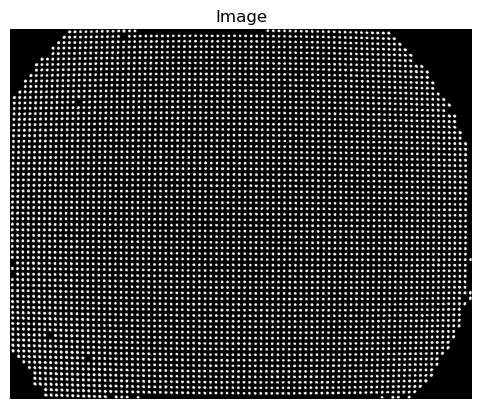

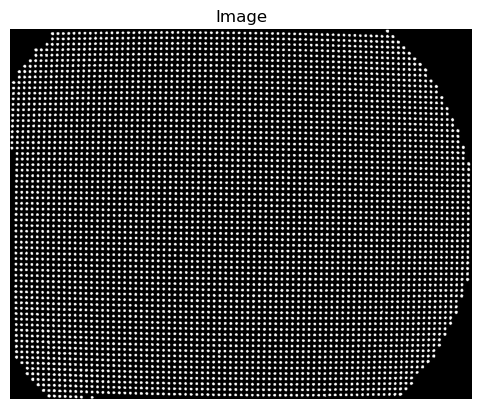

In [12]:
# Remove non-dot objects
dot_size=45
min_size = np.clip(dot_size - 0.5 * dot_size, 0, None)
max_size = dot_size + 0.5 * dot_size
#print (max_size, min_size)    

data0_new= prep.select_dots_based_size(data0_new, dot_size0, ratio=0.4)
plot_image(data0_new)
data1_new= prep.select_dots_based_size(data1_new, dot_size1, ratio=0.4)
plot_image(data1_new)


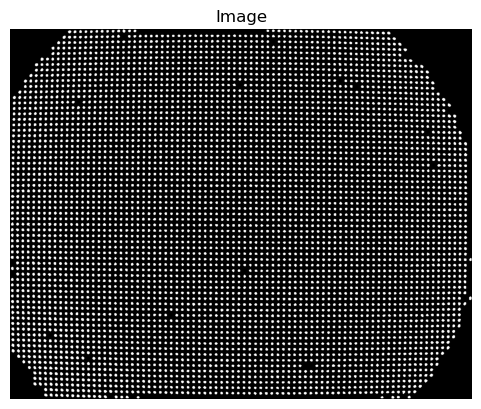

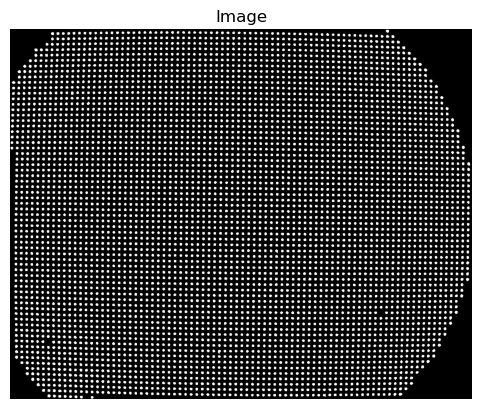

In [13]:
# Remove non-elliptical objects
data0_new = prep.select_dots_based_ratio(data0_new,ratio=0.4)
plot_image(data0_new)
data1_new = prep.select_dots_based_ratio(data1_new,ratio=0.4)
plot_image(data1_new)

In [14]:
# Calculate the slopes of horizontal lines and vertical lines.
hor_slope0 = prep.calc_hor_slope(np.roll(data0_new, 30,1), ratio=0.6)
ver_slope0 = prep.calc_ver_slope(np.roll(data0_new, 30, 1), ratio=0.6)
print (hor_slope0*180./np.pi, ver_slope0*180./np.pi, hor_slope0/ver_slope0, ver_slope0/hor_slope0)
#print("Horizontal slope: {0}. Vertical slope {1}".format(hor_slope0, ver_slope0), ver_slope0/hor_slope0)
hor_slope1 = prep.calc_hor_slope(np.roll(data1_new, 40,1) ,ratio=0.6)
ver_slope1 = prep.calc_ver_slope(np.roll(data1_new, 40,1), ratio=0.6)
print (hor_slope1*180./np.pi, ver_slope1*180./np.pi, hor_slope1/ver_slope1, ver_slope1/hor_slope1)

0.2848437216050983 -0.28953570115489496 -0.983794815177951 -1.0164721185475223
0.5706297558593817 -0.5601728988091114 -1.0186671955614077 -0.9816748829816594


611.121449377752 534.9055819655781
620.0271174480758 535.8304794331979


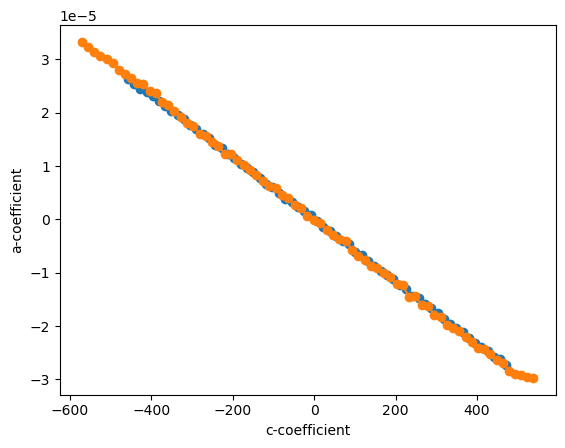

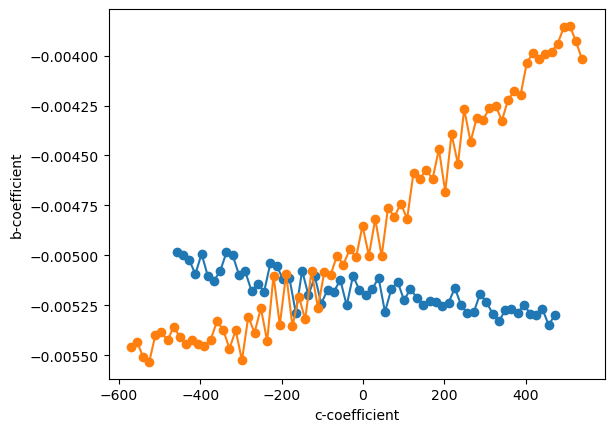

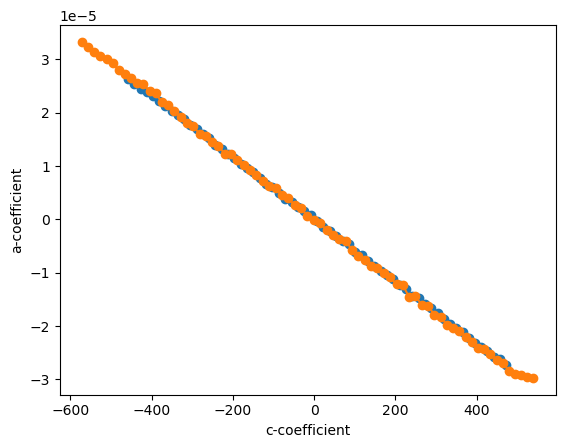

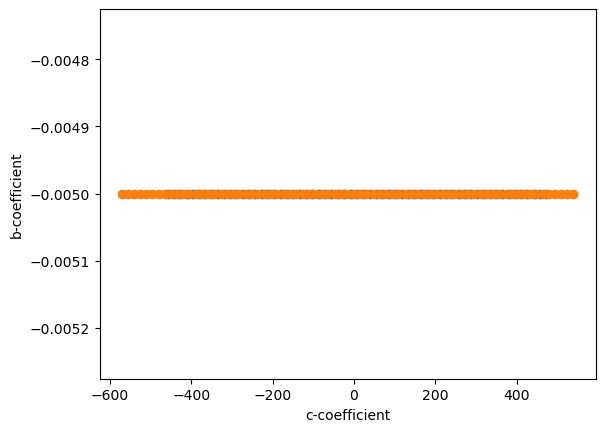

In [15]:
# Group dots into lines.
list_hor_lines0 = prep.group_dots_hor_lines(data0_new, hor_slope0, dot_dist0,
                                                ratio=0.4, num_dot_miss=4, accepted_ratio=0.8)
list_ver_lines0 = prep.group_dots_ver_lines(data0_new, ver_slope0, dot_dist0,
                                                ratio=0.4, num_dot_miss=4, accepted_ratio=0.8)
# Remove outliers
list_hor_lines0 = prep.remove_residual_dots_hor(list_hor_lines0, hor_slope0, residual=2.0)
list_ver_lines0 = prep.remove_residual_dots_ver(list_ver_lines0, ver_slope0, residual=2.0)

# Regenerate grid points with the correction of perspective effect.
list_hor_lines0_new, list_ver_lines0_new = proc.regenerate_grid_points_parabola(list_hor_lines0, list_ver_lines0, perspective=True) 
(xcenter0, ycenter0) = proc.find_cod_coarse(list_hor_lines0_new, list_ver_lines0_new)
print(xcenter0, ycenter0)

# Regenerate the lines without perspective correction for later use.
list_hor_lines0_nop, list_ver_lines0_nop = proc.regenerate_grid_points_parabola(list_hor_lines0, list_ver_lines0, perspective=False)

#plot coeff
# Calculate the center of distortion, but just for parabolic fit.
(xcen_tmp, ycen_tmp) = proc.find_cod_bailey(list_hor_lines0, list_ver_lines0)
print (xcen_tmp, ycen_tmp) 
list_hor_coef = proc._para_fit_hor(list_hor_lines0, xcen_tmp, ycen_tmp)[0]
list_ver_coef = proc._para_fit_ver(list_ver_lines0, xcen_tmp, ycen_tmp)[0]
# Plot the results
plt.figure(0)
plt.plot(list_hor_coef[:, 2], list_hor_coef[:, 0], "-o")
plt.plot(list_ver_coef[:, 2], list_ver_coef[:, 0], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("a-coefficient")

plt.figure(1)
plt.plot(list_hor_coef[:, 2], -list_hor_coef[:, 1], "-o")
plt.plot(list_ver_coef[:, 2], list_ver_coef[:, 1], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("b-coefficient")
plt.show()
# Correct parabola coefficients
hor_coef_corr, ver_coef_corr = proc._generate_non_perspective_parabola_coef(list_hor_lines0, list_ver_lines0)[0:2]
# Plot to check the results
plt.figure(0)
plt.plot(hor_coef_corr[:, 2], hor_coef_corr[:, 0], "-o")
plt.plot(ver_coef_corr[:, 2], ver_coef_corr[:, 0], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("a-coefficient")
plt.figure(1)
plt.plot(hor_coef_corr[:, 2], -hor_coef_corr[:, 1], "-o")
plt.plot(ver_coef_corr[:, 2], ver_coef_corr[:, 1], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("b-coefficient")
plt.show()

591.0747099576957 510.4228168711447
594.5416553266444 513.4034560990069


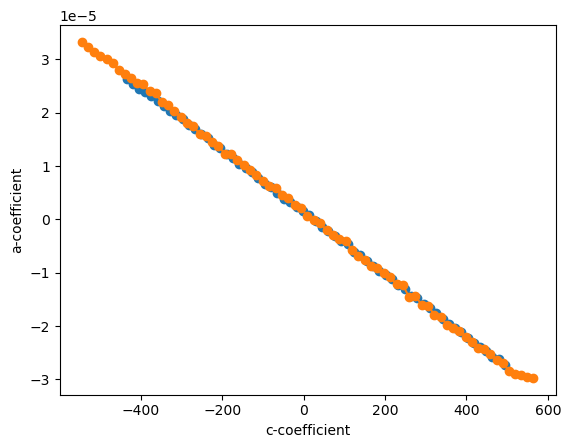

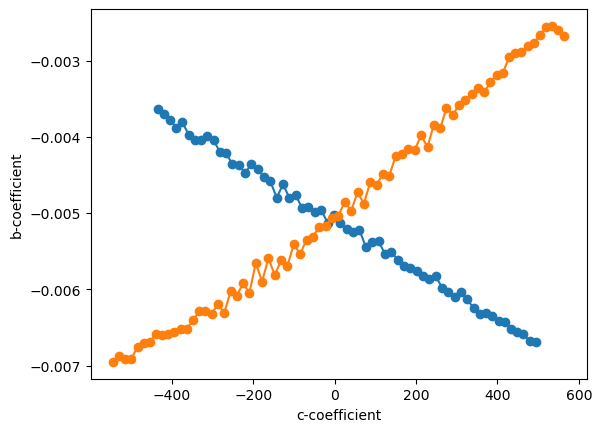

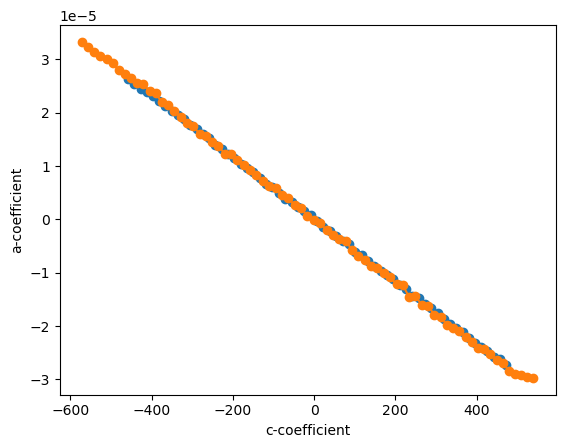

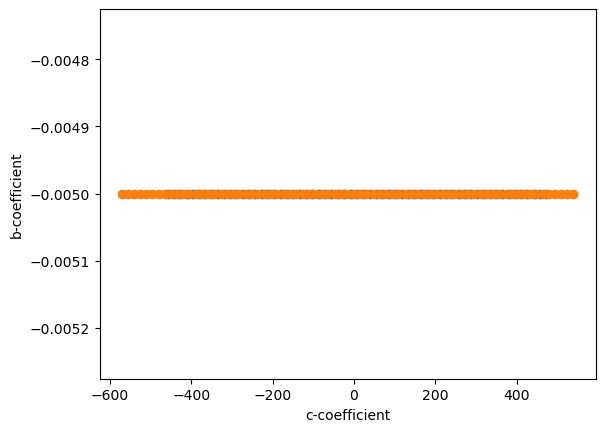

In [16]:
# Group dots into lines.
list_hor_lines1 = prep.group_dots_hor_lines(data1_new, hor_slope1, dot_dist1,
                                                ratio=0.4, num_dot_miss=4, accepted_ratio=0.8)
list_ver_lines1 = prep.group_dots_ver_lines(data1_new, ver_slope1, dot_dist1,
                                                ratio=0.4, num_dot_miss=4, accepted_ratio=0.8)
# Remove outliers
list_hor_lines1 = prep.remove_residual_dots_hor(list_hor_lines1, hor_slope1, residual=2.0)
list_ver_lines1 = prep.remove_residual_dots_ver(list_ver_lines1, ver_slope1, residual=2.0)

# Regenerate grid points with the correction of perspective effect.
list_hor_lines1_new, list_ver_lines1_new = proc.regenerate_grid_points_parabola(list_hor_lines1, list_ver_lines1, perspective=True) 
(xcenter1, ycenter1) = proc.find_cod_coarse(list_hor_lines1_new, list_ver_lines1_new)
print(xcenter1, ycenter1)

# Regenerate the lines without perspective correction for later use.
list_hor_lines1_nop, list_ver_lines1_nop = proc.regenerate_grid_points_parabola( list_hor_lines1, list_ver_lines1, perspective=False)

#plot coeff
# Calculate the center of distortion, but just for parabolic fit.
(xcen_tmp, ycen_tmp) = proc.find_cod_bailey(list_hor_lines1, list_ver_lines1)
print (xcen_tmp, ycen_tmp) 
list_hor_coef = proc._para_fit_hor(list_hor_lines0, xcen_tmp, ycen_tmp)[0]
list_ver_coef = proc._para_fit_ver(list_ver_lines0, xcen_tmp, ycen_tmp)[0]
# Plot the results
plt.figure(0)
plt.plot(list_hor_coef[:, 2], list_hor_coef[:, 0], "-o")
plt.plot(list_ver_coef[:, 2], list_ver_coef[:, 0], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("a-coefficient")

plt.figure(1)
plt.plot(list_hor_coef[:, 2], -list_hor_coef[:, 1], "-o")
plt.plot(list_ver_coef[:, 2], list_ver_coef[:, 1], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("b-coefficient")
plt.show()
# Correct parabola coefficients
hor_coef_corr, ver_coef_corr = proc._generate_non_perspective_parabola_coef(list_hor_lines0, list_ver_lines0)[0:2]
# Plot to check the results
plt.figure(0)
plt.plot(hor_coef_corr[:, 2], hor_coef_corr[:, 0], "-o")
plt.plot(ver_coef_corr[:, 2], ver_coef_corr[:, 0], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("a-coefficient")
plt.figure(1)
plt.plot(hor_coef_corr[:, 2], -hor_coef_corr[:, 1], "-o")
plt.plot(ver_coef_corr[:, 2], ver_coef_corr[:, 1], "-o")
plt.xlabel("c-coefficient")
plt.ylabel("b-coefficient")
plt.show()

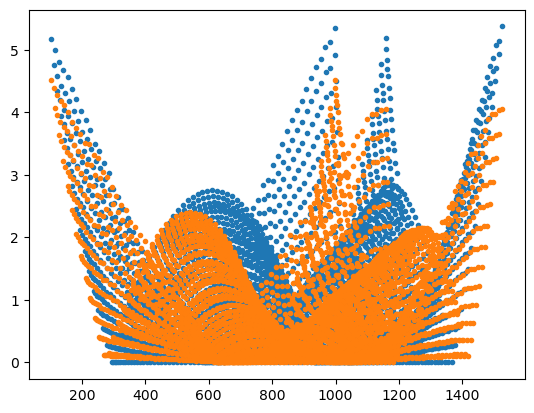

In [17]:
list_hor_data0 = post.calc_residual_hor(list_hor_lines0_new, 0.0, 0.0)
list_ver_data0 = post.calc_residual_ver(list_ver_lines0_new, 0.0, 0.0)
plt.plot(list_hor_data0[:, 0],list_hor_data0[:, 1],  '.')
plt.plot(list_ver_data0[:, 0], list_ver_data0[:,1], '.')



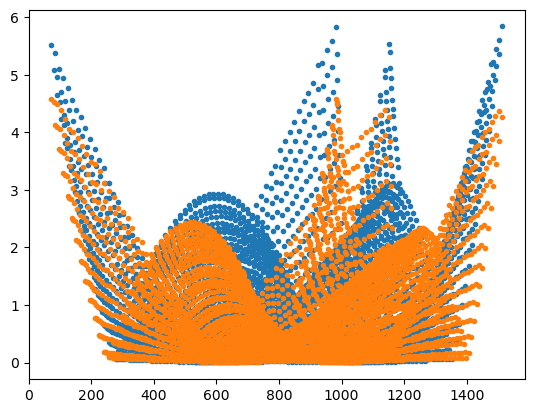

In [18]:
list_hor_data1 = post.calc_residual_hor(list_hor_lines1_new, 0.0, 0.0)
list_ver_data1 = post.calc_residual_ver(list_ver_lines1_new, 0.0, 0.0)
plt.plot(list_hor_data1[:, 0],list_hor_data1[:, 1],  '.')
plt.plot(list_ver_data1[:, 0], list_ver_data1[:,1], '.')


In [19]:
# Calculate the center of distortion
# use option with no perspective 
(xcenter0, ycenter0) = proc.find_cod_bailey(list_hor_lines0, list_ver_lines0)
print(xcenter0, ycenter0)
# Calculate coefficients of the correction model without perspective 
list_fact0_nop = proc.calc_coef_backward(list_hor_lines0, list_ver_lines0, xcenter0, ycenter0, num_coef)

# Calculate the center of distortion using perspective corrected lines
(xcenter0, ycenter0) = proc.find_cod_fine(list_hor_lines0_new, list_ver_lines0_new, xcenter0, ycenter0, dot_dist0)
print (xcenter0, ycenter0) 
(xcenter0, ycenter0) = proc.find_cod_bailey(list_hor_lines0_new, list_ver_lines0_new)
print (xcenter0, ycenter0) 

# Calculate coefficients of the correction model, including perspective, with new center
list_fact0 = proc.calc_coef_backward(list_hor_lines0_new, list_ver_lines0_new, xcenter0, ycenter0, num_coef)
print("Coefficients: {0}".format(list_fact0))
print("Coefficients: {0}".format(list_fact0_nop))

print (list_fact0/list_fact0_nop)

620.0271174480758 535.8304794331979
620.1805119801986 535.9838739653206
620.0270885949633 535.8305153655785
Coefficients: [ 1.00065474e+00 -5.98978656e-06 -2.52012103e-08 -6.79066102e-11
  5.11091141e-14]
Coefficients: [ 1.00072757e+00 -7.19168742e-06 -2.00805901e-08 -7.48167247e-11
  5.33392963e-14]
[0.99992722 0.83287638 1.25500348 0.90763944 0.95818876]


In [20]:
# Calculate the center of distortion
# use option with no perspective
(xcenter1, ycenter1) = proc.find_cod_bailey(list_hor_lines1, list_ver_lines1)
print(xcenter1, ycenter1)
# Calculate coefficients of the correction model without perspective 
list_fact1_nop = proc.calc_coef_backward(list_hor_lines1, list_ver_lines1, xcenter1, ycenter1, num_coef)

(xcenter1, ycenter1) = proc.find_cod_fine(list_hor_lines1_new, list_ver_lines1_new, xcenter1, ycenter1, dot_dist1)
print (xcenter1, ycenter1) 
(xcenter1, ycenter1) = proc.find_cod_bailey(list_hor_lines1_new, list_ver_lines1_new)
print (xcenter1, ycenter1) 

# Calculate coefficients of the correction model, including perspective, with new center
list_fact1 = proc.calc_coef_backward(list_hor_lines1_new, list_ver_lines1_new, xcenter1, ycenter1, num_coef)
print("Coefficients: {0}".format(list_fact1))
print("Coefficients: {0}".format(list_fact1_nop))
print (list_fact1/list_fact1_nop)

594.5416553266444 513.4034560990069
594.7170169183129 513.5788176906754
594.5417229221399 513.4034054346442
Coefficients: [ 1.00085083e+00 -7.51150738e-06 -2.89869687e-08 -4.74510052e-11
  3.15363448e-14]
Coefficients: [ 1.00080620e+00 -6.70041739e-06 -3.31197190e-08 -3.98153339e-11
  2.68640826e-14]
[1.00004459 1.12105067 0.87521783 1.19177715 1.17392227]


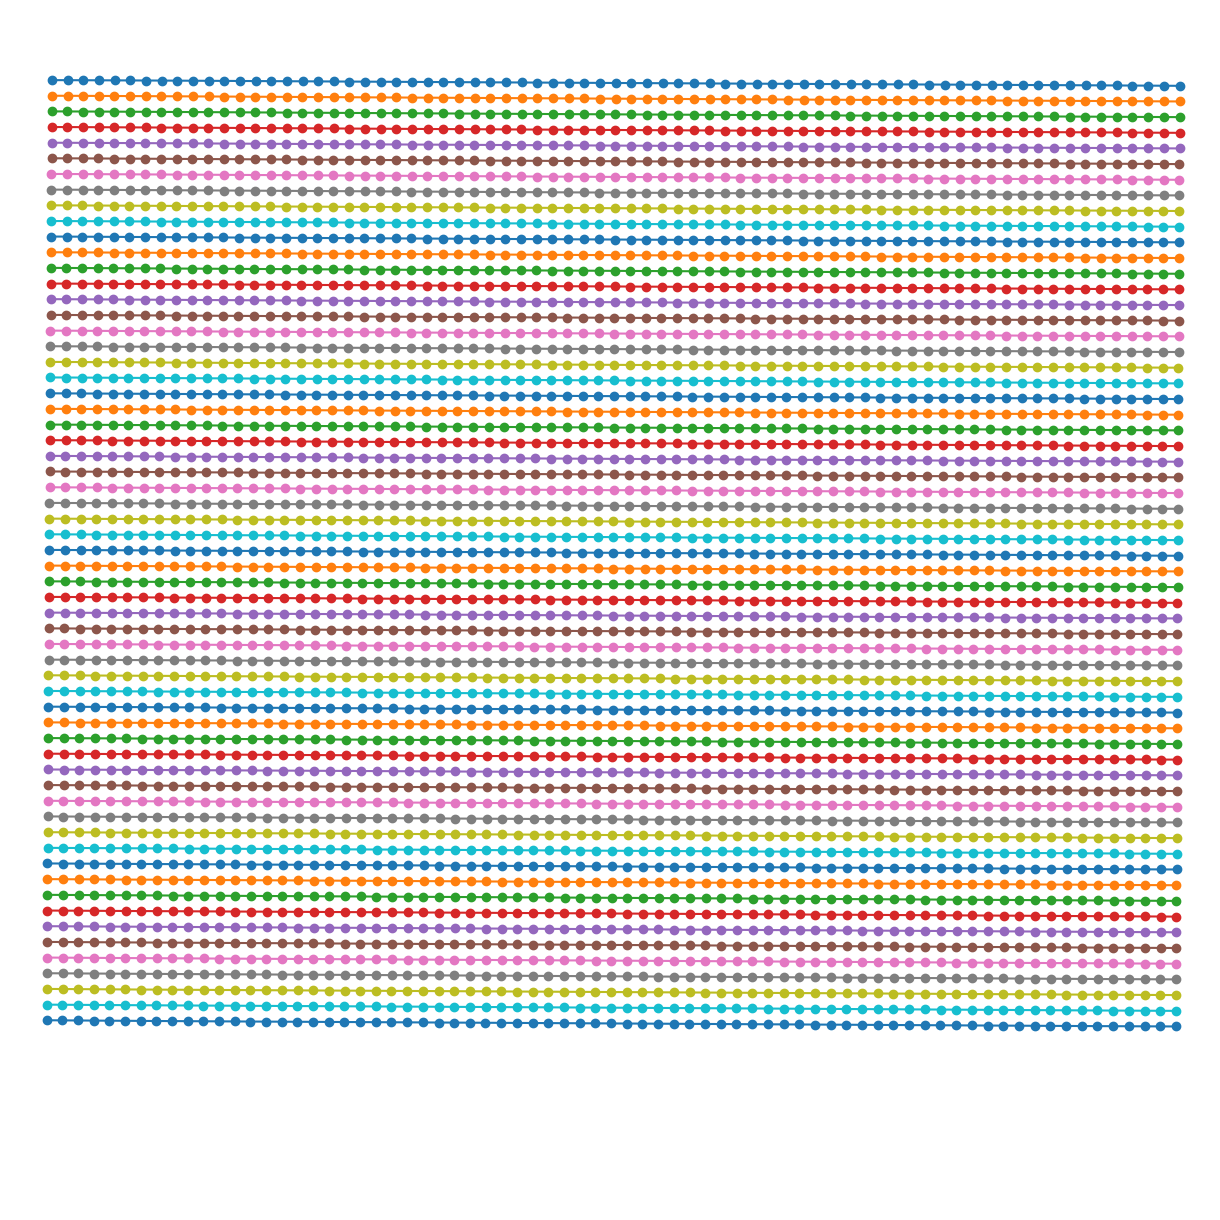

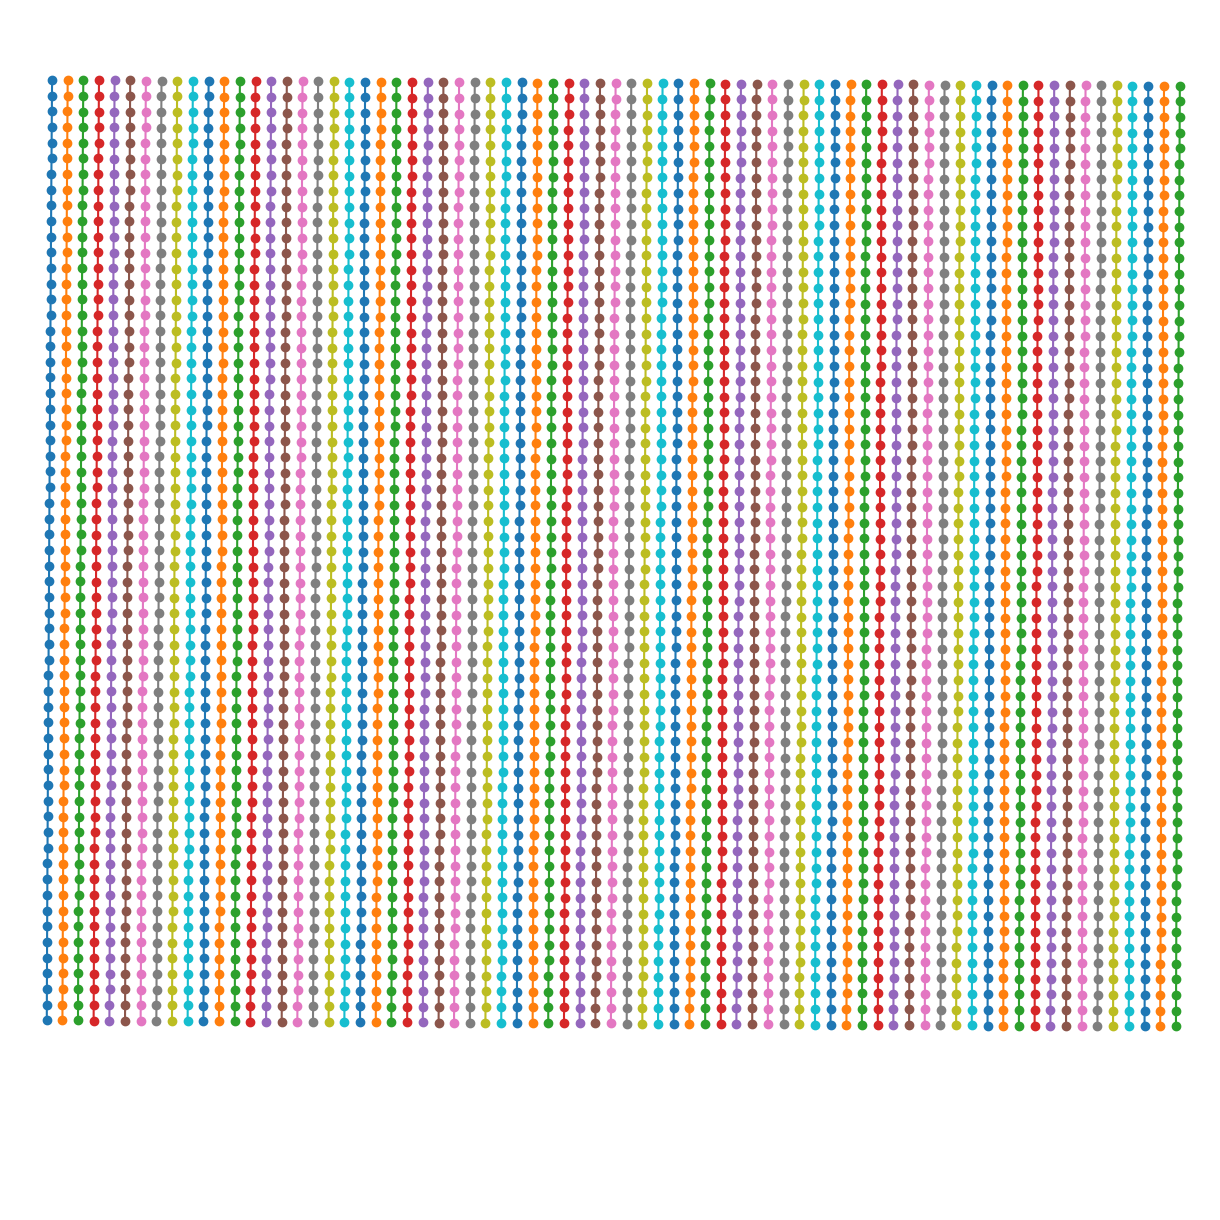

In [21]:
# Unwarp lines using the backward model:
list_uhor_lines0 = post.unwarp_line_backward(list_hor_lines0_nop, xcenter0, ycenter0, list_fact0)
list_uver_lines0 = post.unwarp_line_backward(list_ver_lines0_nop, xcenter0, ycenter0, list_fact0)
# Save the results for checking
plot_image_view(list_uhor_lines0, 1200,1200)
plot_image_view(list_uver_lines0, 1200,1200)

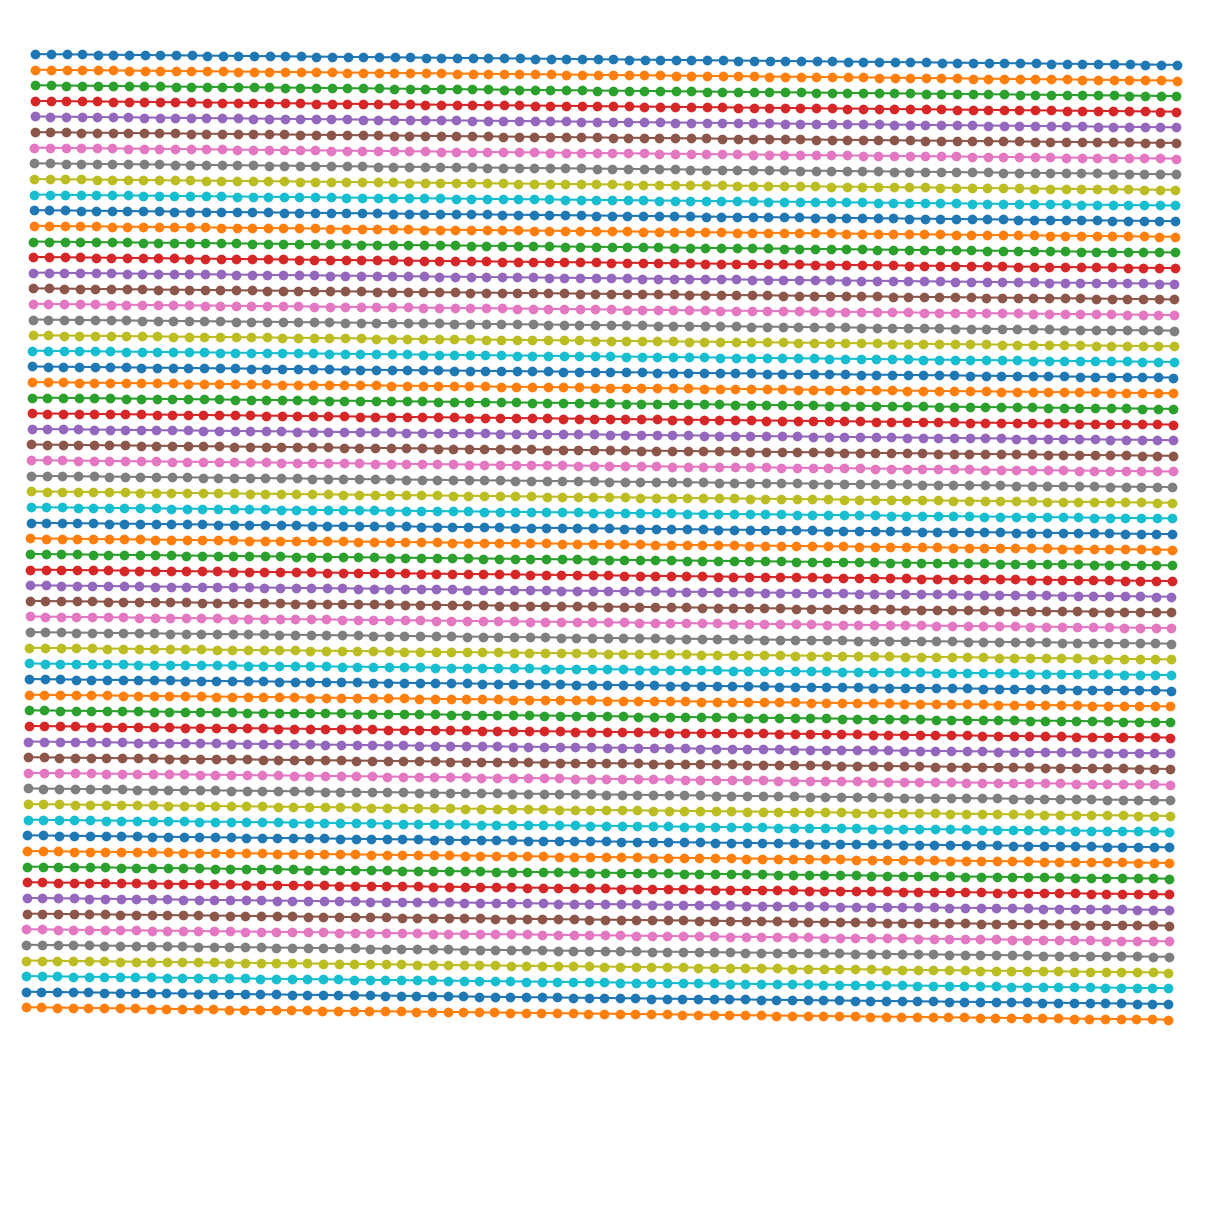

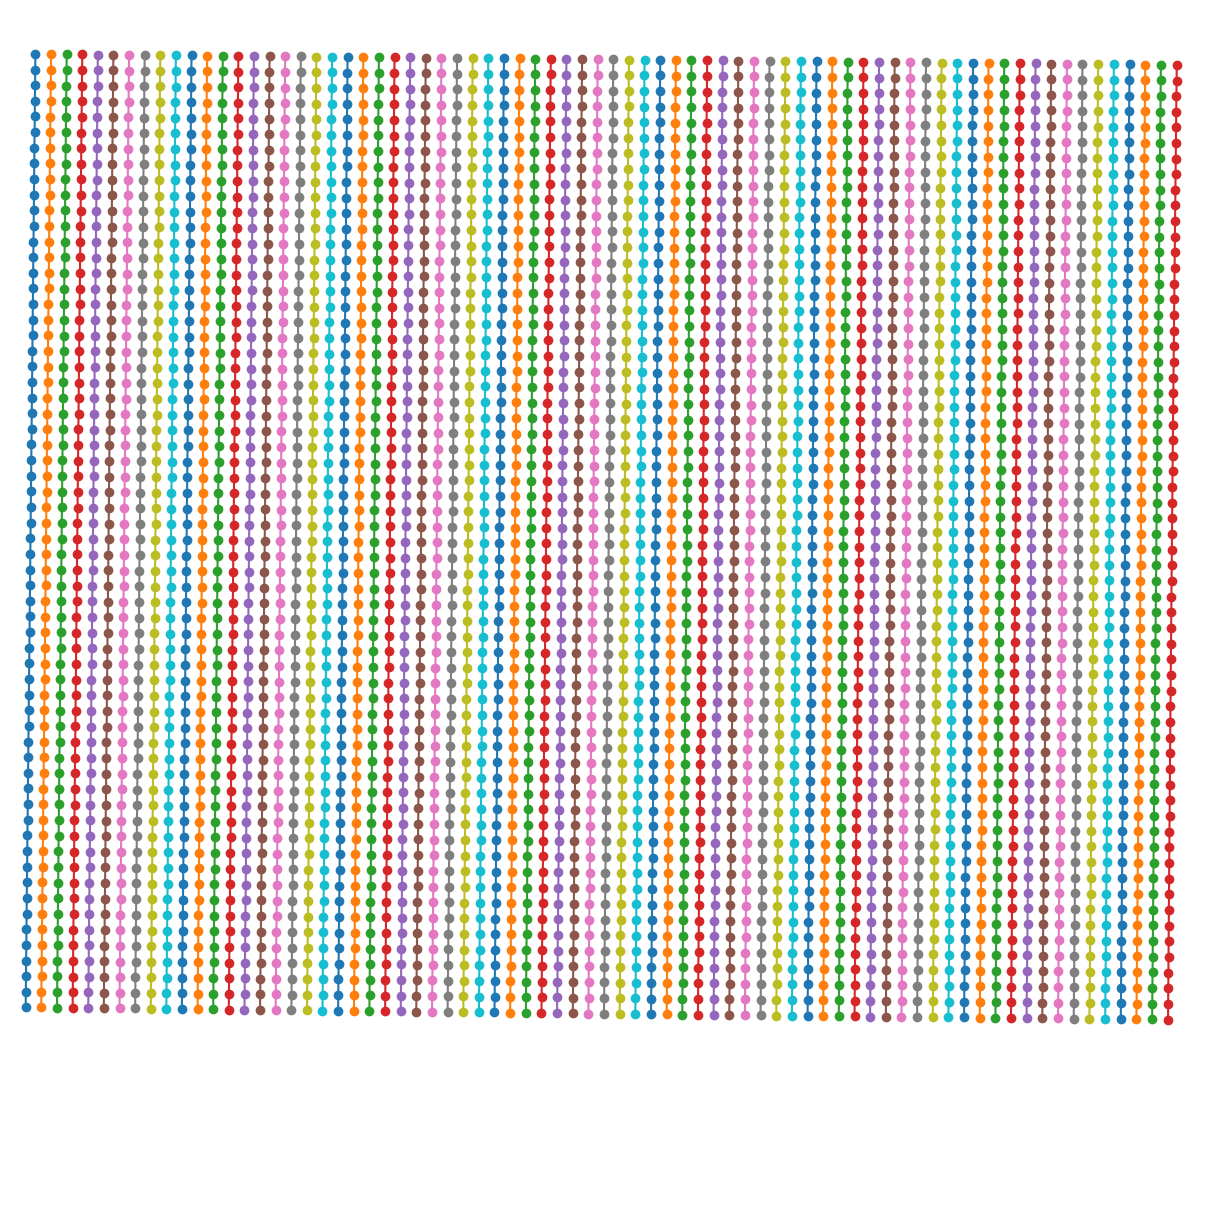

In [22]:
# Apply correction to the lines of points
list_uhor_lines1 = post.unwarp_line_backward(list_hor_lines1_nop, xcenter1, ycenter1, list_fact1)
list_uver_lines1 = post.unwarp_line_backward(list_ver_lines1_nop, xcenter1, ycenter1, list_fact1)
# Save the results for checking
plot_image_view(list_uhor_lines1, 1200,1200)
plot_image_view(list_uver_lines1, 1200,1200)


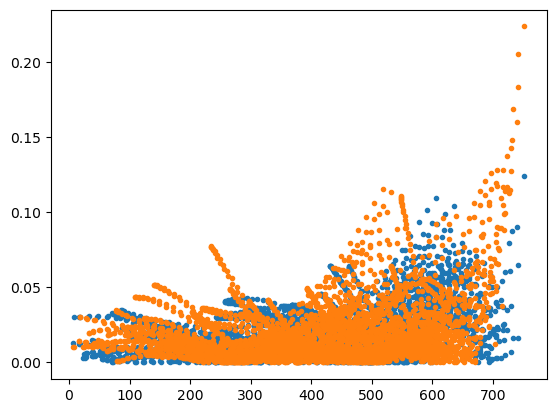

In [23]:
list_hor_data0 = post.calc_residual_hor(list_uhor_lines0, xcenter0, ycenter0)
list_ver_data0 = post.calc_residual_ver(list_uver_lines0, xcenter0, ycenter0)

plt.plot(list_hor_data0[:, 0],list_hor_data0[:, 1],  '.')
plt.plot(list_ver_data0[:, 0], list_ver_data0[:,1], '.')

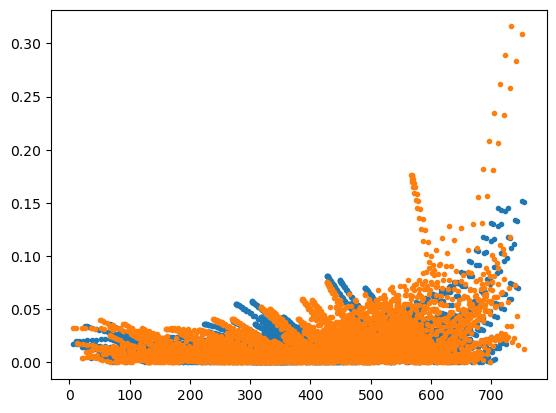

In [24]:
list_hor_data1 = post.calc_residual_hor(list_uhor_lines1, xcenter1, ycenter1)
list_ver_data1 = post.calc_residual_ver(list_uver_lines1, xcenter1, ycenter1)

plt.plot(list_hor_data1[:, 0], list_hor_data1[:, 1],  '.')
plt.plot(list_ver_data1[:, 0], list_ver_data1[:,1], '.')

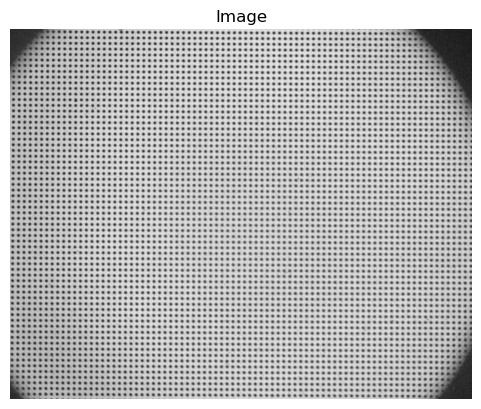

-347.312 5800.7217


In [25]:
corrected_data0 = post.unwarp_image_backward(data0, xcenter0, ycenter0, list_fact0)
plot_image(corrected_data0)
print (np.min(corrected_data0), np.max(corrected_data0))

In [1]:
corrected_data1 = post.unwarp_image_backward(data1, xcenter1, ycenter1, list_fact1)
plot_image(corrected_data1)
print (np.min(corrected_data1), np.max(corrected_data1))

NameError: name 'post' is not defined

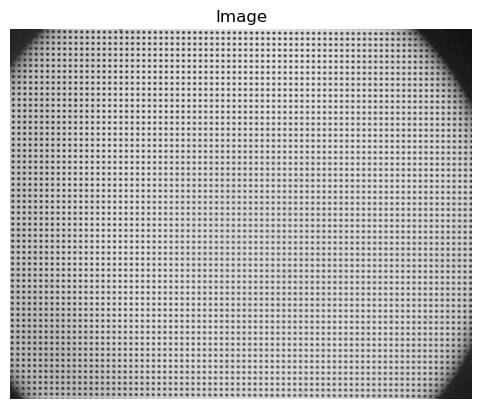

1024 1280


In [27]:
# Generate source points and target points to calculate coefficients of a perspective model
source_points0, target_points0 = proc.generate_source_target_perspective_points(list_uhor_lines0, list_uver_lines0,
                                                                              equal_dist=True, scale="mean", optimizing=False)
#print (target_points0[1000:1020,0]-target_points0[999:1019,0])
# Calculate perspective coefficients:
pers_coef0 = proc.calc_perspective_coefficients(source_points0, target_points0, mapping="backward")
corrected_data0_pers = post.correct_perspective_image(corrected_data0, pers_coef0)
# Save results
plot_image(corrected_data0_pers)
(height0, width0) = corrected_data0_pers.shape
print (height0, width0)

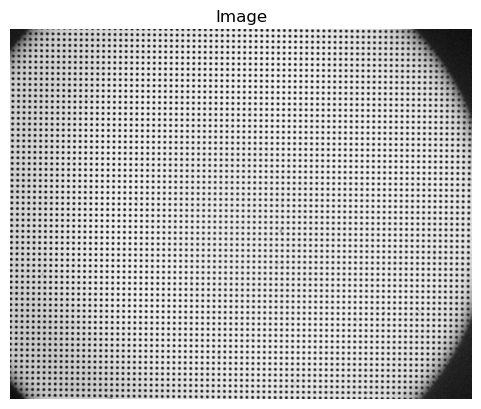

1024 1280


In [28]:
# Generate source points and target points to calculate coefficients of a perspective model
source_points1, target_points1 = proc.generate_source_target_perspective_points(list_uhor_lines1, list_uver_lines1,
                                                                              equal_dist=True, scale="mean",
                                                                              optimizing=False)
#print (target_points1[1000:1020,0]-target_points1[999:1019,0])
# Calculate perspective coefficients:
pers_coef1 = proc.calc_perspective_coefficients(source_points1, target_points1, mapping="backward")
corrected_data1_pers = post.correct_perspective_image(corrected_data1, pers_coef1)
# Save results
#plot_image(corrected_data1 - corrected_data1_pers)
plot_image(corrected_data1_pers)
(height1, width1) = corrected_data1_pers.shape
print (height1, width1)

In [29]:
corrected_data0_new = post.unwarp_image_backward(data0_new, xcenter0, ycenter0, list_fact0)
(dot_size0, dot_dist0) = prep.calc_size_distance(corrected_data0_new, ratio=0.5)
print(dot_size0, dot_dist0) 
corrected_data1_new = post.unwarp_image_backward(data1_new, xcenter1, ycenter1, list_fact1)
(dot_size1, dot_dist1) = prep.calc_size_distance(corrected_data1_new, ratio=0.5)
print(dot_size1, dot_dist1) 

44.0 15.36132947626687
47.0 15.361834737448469


In [32]:
from astropy.io import fits
hdu = fits.ImageHDU()
hdu.data = np.array(corrected_data0_pers)
hdu.writeto('new_image0.fits', overwrite=1)

from astropy.io import fits
hdu = fits.ImageHDU()
hdu.data = np.array(corrected_data1_pers)
hdu.writeto('new_image1.fits', overwrite=1)

In [31]:
#test=list_uhor_lines0[10]
#print(test[1:73,:]-test[0:72,:]-[0.08,15.5])

#test=list_uver_lines0[30]
#print (test[1:61,:]-test[0:60,:])

#test= list_hor_lines0[10]
#test2=list_hor_lines0_new[10]
